PROBABILIDAD DE DEFAULT DE LOS TITULOS ARGENTINOS

In [1]:
#Importo librerias (e instalo alguna si hace falta)
#pip install yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import scipy.optimize as sco
from scipy import interpolate
import statsmodels.api as sm
import pandas_datareader as pdr
import datetime

In [3]:
#Import the cash flows of the national bond AL30
Bonds_LocalLaw = ['AL29', 'AL30', 'AL35', 'AE38', 'AL41']
Bonds_ForeignLaw = ['GD29', 'GD30', 'GD35', 'GD38', 'GD41', 'GD46']

Bonds = Bonds_LocalLaw + Bonds_ForeignLaw

excel = 'C:/Users/juana/OneDrive/UCEMA/Quant - Finanzas Cuantitativas/TP Final/GitHub/tp_quant_Git Desktop/tp_quant/Input.xlsx'
data_frames = []

for i in Bonds:
    sheet = i
    df = pd.read_excel(excel, sheet_name=sheet, index_col='Fecha Pago')
    df.index = pd.to_datetime(df.index)
    data_frames.append({i: df})

Bonds_CashFlows = {nombre: dataframe for elemento in data_frames for nombre, dataframe in elemento.items()}


#Import the prices of each day
#sheet = 'PRICES Local Law'

sheet_AL = 'PRICES Local Law'
sheet_GD = 'PRICES Foreign Law'
data_frames = []

df_AL = pd.read_excel(excel, sheet_name=sheet_AL, index_col='date')

for i in Bonds_LocalLaw:
    df = df_AL[i]
    df = pd.DataFrame(df)
    df.index = pd.to_datetime(df.index)
    data_frames.append({i: df})

df_GD = pd.read_excel(excel, sheet_name=sheet_GD, index_col='date')

for i in Bonds_ForeignLaw:
    df = df_GD[i]
    df = pd.DataFrame(df)
    df.index = pd.to_datetime(df.index)
    data_frames.append({i: df})

Bonds_Prices = {nombre: dataframe for elemento in data_frames for nombre, dataframe in elemento.items()}




In [4]:
#Supuestos Iniciales
#Recovery Rate
RR = 0.3
#Estructura Temporal de Tasas de Interés
#ETTI = {'Days': range(1,10000), 'Rate': 0.4469}
#ETTI = {'Days': range(1,10000), 'Rate': 0.04}
#ETTI = pd.DataFrame(ETTI)
#ETTI = ETTI.set_index('Days')
#ETTI

In [5]:
#Buscando la ETTI Risk Free de USA.

#Para ver gráficamente cómo sería la interpolación
def EjemploSplineInterpolator(x, y):
    tck1 = interpolate.splrep(x, y, s=0)
    tck2 = interpolate.splrep(x, y, s=1)
    xForPlot = np.linspace(0, 10950, num=10951, endpoint=True)
    yForPlot1 = interpolate.splev(xForPlot, tck1, der=0)
    yForPlot2 = interpolate.splev(xForPlot, tck2, der=0)
    plt.figure(4)
    plt.plot(x, y, 'o', linewidth=0, label="data")
    plt.plot(xForPlot, yForPlot1, '-', label="Spline smoothness=0")
    plt.plot(xForPlot, yForPlot2, '--', label="Spline smoothness=1")
    plt.legend()
    plt.show()

#Armo función que interpolaría

def interpolador(date, historical_rates):
    date = pd.to_datetime(date)
    x = historical_rates.columns.to_list()
    y = historical_rates.loc[date].to_list()
    tck = interpolate.splrep(x, y, s=0)
    return tck



In [6]:

# Importar curva de tasas de interés desde FRED

#Tickers de los Bonos del Tesoro Americano de cada vencimiento
t1m = 'DGS1MO'
t3m = 'DGS3MO'
t6m = 'DGS6MO'
t1y = 'DGS1'
t2y = 'DGS2'
t3y = 'DGS3'
t5y = 'DGS5'
t7y = 'DGS7'
t10y = 'DGS10'
t20y = 'DGS20'
t30y = 'DGS30'

# Fecha de inicio y fecha de fin para los datos históricos.

start_date = datetime.date(2020, 9, 1)
end_date = datetime.date(2023, 10, 26)

# Obtener datos de la curva de tasas de interés desde FRED
nodo1m = pdr.get_data_fred(t1m, start_date, end_date)
nodo3m = pdr.get_data_fred(t3m, start_date, end_date)
nodo6m = pdr.get_data_fred(t6m, start_date, end_date)
nodo1y = pdr.get_data_fred(t1y, start_date, end_date)
nodo2y = pdr.get_data_fred(t2y, start_date, end_date)
nodo3y = pdr.get_data_fred(t3y, start_date, end_date)
nodo5y = pdr.get_data_fred(t5y, start_date, end_date)
nodo7y = pdr.get_data_fred(t7y, start_date, end_date)
nodo10y = pdr.get_data_fred(t10y, start_date, end_date)
nodo20y = pdr.get_data_fred(t20y, start_date, end_date)
nodo30y = pdr.get_data_fred(t30y, start_date, end_date)


In [7]:
#Rangos de fechas que quisiera tener una ETTI, pongo todos los días hasta los fines de semana para evitar el error en los que hubo feriado en USA y no en Argentina y viceversa
fechas_intermedias = [start_date + datetime.timedelta(days=d) for d in range((end_date - start_date).days + 1)]
fechas_intermedias
fechas = pd.DataFrame({'Fecha': fechas_intermedias})
fechas = fechas.set_index('Fecha')
fechas

Curvas = fechas
Curvas = Curvas.join(nodo1m, how="left")
Curvas = Curvas.join(nodo3m, how="left")
Curvas = Curvas.join(nodo6m, how="left")
Curvas = Curvas.join(nodo1y, how="left")
Curvas = Curvas.join(nodo2y, how="left")
Curvas = Curvas.join(nodo3y, how="left")
Curvas = Curvas.join(nodo5y, how="left")
Curvas = Curvas.join(nodo7y, how="left")
Curvas = Curvas.join(nodo10y, how="left")
Curvas = Curvas.join(nodo20y, how="left")
Curvas = Curvas.join(nodo30y, how="left")
Curvas = Curvas.fillna(method='ffill')
nuevos_nombres = {'DGS1MO': 30, 'DGS3MO': 90, 'DGS6MO': 180, 'DGS1': 365, 'DGS2': 730, 'DGS3': 1095, 'DGS5': 1825, 'DGS7': 2555, 'DGS10': 3650, 'DGS20': 7300, 'DGS30': 10950}
Curvas.rename(columns=nuevos_nombres, inplace=True)

El valor interpolado en x = 2.5 es y = 6.25


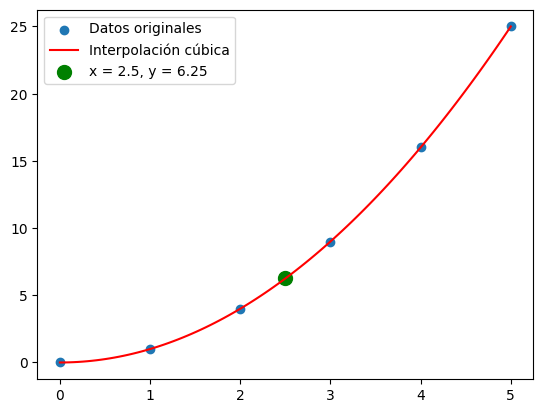

In [11]:
import numpy as np
from scipy.interpolate import splrep, splev
import matplotlib.pyplot as plt

# Datos de ejemplo (abscisas y ordenadas)
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([0, 1, 4, 9, 16, 25])

# Realizar interpolación cúbica
tck = splrep(x, y)

# Valor de abscisa donde deseas evaluar la función interpolante
x_eval = 2.5

# Evaluar la función interpolante en x_eval
y_eval = splev(x_eval, tck)

# Imprimir el resultado
print(f"El valor interpolado en x = {x_eval} es y = {y_eval}")

# Graficar los datos originales y la interpolación
x_new = np.linspace(x.min(), x.max(), 100)
y_new = splev(x_new, tck)

plt.scatter(x, y, label="Datos originales")
plt.plot(x_new, y_new, label="Interpolación cúbica", color='red')
plt.scatter(x_eval, y_eval, color='green', label=f'x = {x_eval}, y = {y_eval}', s=100)
plt.legend()
plt.show()



In [8]:
#Creo función para calcular los precios del AL30 según cada curva de tasas
def NPV(cf, date, historical_rates):
    date = pd.to_datetime(date)
    cf2 = cf.loc[cf.index > date, ['A+R']]
    cf2['Days to payment'] = (cf2.index - date).days
#    cf2['Risk Free Rate'] = cf2['Days to payment'].map(rates['Rate'])
    cf2['Risk Free Rate'] = interpolate.splev(cf2['Days to payment'],interpolador(date, historical_rates))/100
    cf2['Present Value Factor'] = (1 + cf2['Risk Free Rate'] )**-(cf2['Days to payment']/365)
    cf2['Cash Flow Present Value'] = cf2['A+R'] * cf2['Present Value Factor']
    price = sum(cf2['Cash Flow Present Value'])
    return price

NPV(Bonds_CashFlows['AL30'], '2023-09-19' , Curvas )


87.39974680799335

In [9]:
#Para el cálculo de la pérdida esperada a cada momento y traerlo a valor actual necesito calcular
#la curva forward en ese momento para traerlo y por eso es que creo esta función
def NPV_Forward(cf, date, date_forward, historical_rates):
    date = pd.to_datetime(date)
    cf2 = cf.loc[cf.index > date, ['A+R']]
    date_forward = pd.to_datetime(date_forward)
    cf2 = cf2.loc[cf2.index >= date_forward, ['A+R']]
    cf2['Days to payment'] = (cf2.index - date).days
#    cf2['Risk Free Rate'] = cf2['Days to payment'].map(rates['Rate'])
    cf2['Risk Free Rate'] = interpolate.splev(cf2['Days to payment'],interpolador(date, historical_rates))/100
#    cf2['Present Value Factor'] = (1 + cf2['Risk Free Rate'] )**-(cf2['Days to payment']/365)
    cf2['Fwd Risk Free Rate'] = ((1+ cf2['Risk Free Rate'])**(cf2['Days to payment']/365) / (1+ cf2['Risk Free Rate'][0])**(cf2['Days to payment'][0]/365))**(365/(cf2['Days to payment'] - cf2['Days to payment'][0])) -1
    cf2['Fwd Present Value Factor'] = (1 + cf2['Fwd Risk Free Rate'])**-((cf2['Days to payment']-cf2['Days to payment'][0])/365)
    cf2['Cash Flow Present Value'] = cf2['A+R'] * cf2['Fwd Present Value Factor']
    price = sum(cf2['Cash Flow Present Value'])
    return price

NPV_Forward(Bonds_CashFlows['AL30'], '2023-09-19' , Bonds_CashFlows['AL30'][Bonds_CashFlows['AL30'].index > pd.to_datetime('2023-09-19')].index[2], Curvas )

88.70534182659152

df = pd.DataFrame(interpolador('19-9-2023', Curvas)[0:2], columns=['Columna1', 'Columna2'])
df
interpolador('19-9-2023', Curvas)
#to_excel('C:/Users/juana/OneDrive/UCEMA/Quant - Finanzas Cuantitativas/TP Final/tuplas.xlsx', index=False)

In [10]:
#Armo función para calcular el valor actual de la pérdida esperada a cada fecha
def LossPV(cf, date, historical_rates):
    date = pd.to_datetime(date)
    cf2 = cf.loc[cf.index > date, ['VR','A+R']]
#    cf2['Risk Free Price'] = [NPV_Forward(cf2, dates, date_forward, historical_rates) + cupon['A+R'] for dates, cupon in cf2.iterrows()]
    cf2['Risk Free Price'] = [NPV_Forward(cf, date, dates, historical_rates) for dates, cupon in cf2.iterrows()]
    cf2['Recovery'] = cf2['VR'] * RR
    cf2['Default Loss'] = cf2['Risk Free Price'] - cf2['Recovery']
    cf2['Days to payment'] = (cf2.index - date).days
    #cf2['Risk Free Rate'] = cf2['Days to payment'].map(ETTI['Rate'])
    cf2['Risk Free Rate'] = interpolate.splev(cf2['Days to payment'],interpolador(date, historical_rates))/100
    cf2['Present Value Factor'] = (1 + cf2['Risk Free Rate'] )**-(cf2['Days to payment']/365)
    cf2['Present Value of Default Loss'] = cf2['Present Value Factor'] * cf2['Default Loss']
    PVDL = sum(cf2['Present Value of Default Loss'])
    return PVDL

LossPV(Bonds_CashFlows['AL30'],'2023-09-19', Curvas)


470.15073323917346

In [15]:
# Armo un data Frame donde voy a ir colocando cada uno de las columnas para el
#cálculo de las probabilidades

summary = Bonds_Prices['AL30']
summary['Risk Free Value'] = [NPV(Bonds_CashFlows['AL30'], dates, Curvas) for dates, prices in summary.iterrows()]
summary['Credit Spread'] = summary['Risk Free Value'] - summary.iloc[:, 0]
summary['Present Value of Default Loss'] = [LossPV(Bonds_CashFlows['AL30'], dates, Curvas) for dates, prices in summary.iterrows()]
summary['Default Probability'] = summary['Credit Spread'] / summary['Present Value of Default Loss'] * 2


In [11]:
# Armo un Data Frame donde voy a ir colocando cada uno de las columnas para el
#cálculo de las probabilidades

def PDs(historical_prices, cash_flows, historical_rates):

#historical_prices: sería la matriz de precios y fechas del activo

    summary = historical_prices
    summary['Risk Free Value'] = [NPV(cash_flows, dates, historical_rates) for dates, prices in summary.iterrows()]
    summary['Credit Spread'] = summary['Risk Free Value'] - summary.iloc[:, 0]
    summary['Present Value of Default Loss'] = [LossPV(cash_flows, dates, historical_rates) for dates, prices in summary.iterrows()]
    summary['Default Probability'] = summary['Credit Spread'] / summary['Present Value of Default Loss'] * 2
    Default_Prob = summary['Default Probability']
    Default_Prob = pd.DataFrame(Default_Prob)
    Default_Prob.columns = [summary.columns[0]]
    return Default_Prob

#PDs(Bonds_Prices['AL30'], Bonds_CashFlows['AL30'], Curvas)

In [12]:
#summary.to_excel('C:/Users/juana/OneDrive/UCEMA/Quant - Finanzas Cuantitativas/TP Final/GitHub/tp_quant_Git Desktop/Summary.xlsx', index=True)
#Pruebas de la evolución de Default:

#Graficar los Ley Local y Ley Extranjera
#Graficar La prob promedio de lo que es Ley Local y Ley Extranjera y también el GAP entre ambas
#Graficar la prob promedio según fecha de Vto

#Incorporar quizás fechas importantes que podrían haber hecho saltos en el Riesgo País o Prob de Default


In [12]:
#Graficar los Ley Local y Ley Extranjera
# Como primer paso voy a armar un Data Frame con las PDs de los Ley Local y otro con los Ley Extranjera

PDs_LocalLaw = pd.DataFrame()

for i in Bonds_LocalLaw:
    PDs_LocalLaw[i] = PDs(Bonds_Prices[i], Bonds_CashFlows[i], Curvas)

PDs_LocalLaw

PDs_ForeignLaw = pd.DataFrame()

for i in Bonds_ForeignLaw:
    PDs_ForeignLaw[i] = PDs(Bonds_Prices[i], Bonds_CashFlows[i], Curvas)

PDs_ForeignLaw

,GD29,GD30,GD35,GD38,GD41,GD46
date,,,,,,
2020-09-14,0.113340,0.111136,0.082928,0.083893,0.076028,0.073700
2020-09-15,0.113343,0.111138,0.082929,0.083894,0.076029,0.073704
2020-09-16,0.119526,0.115188,0.084766,0.085867,0.077898,0.073740
2020-09-17,0.126301,0.119171,0.086139,0.086333,0.079664,0.074224
2020-09-18,0.125264,0.117757,0.086588,0.087178,0.079677,0.073886
...,...,...,...,...,...,...
2023-10-20,0.265148,0.229041,0.120738,0.118118,0.105707,0.111787
2023-10-23,0.264694,0.252188,0.125196,0.120990,0.105742,0.109869
2023-10-24,0.273979,0.243931,0.124954,0.127104,0.111661,0.116070


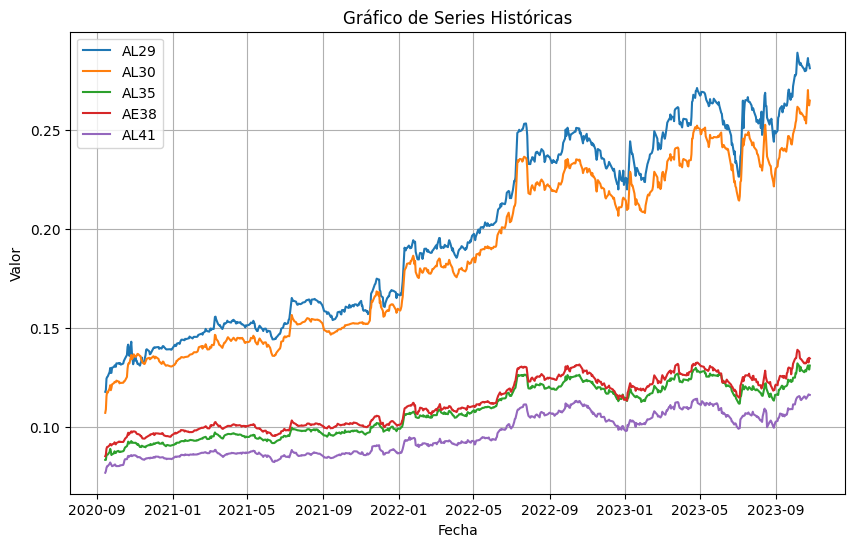

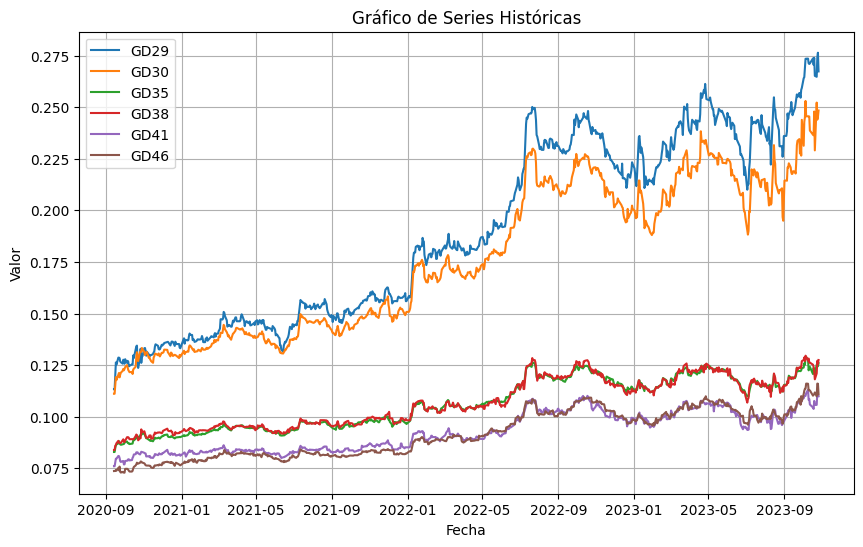

In [30]:
#Grafico las PDs de cada Bono de Ley Local

# Crear un gráfico de líneas para cada serie con leyenda
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

# Graficar cada serie y agregar una leyenda

for i in Bonds_LocalLaw:
    plt.plot(PDs_LocalLaw.index, PDs_LocalLaw[i], label=i)

# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Gráfico de Series Históricas')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)

# Mostrar el gráfico
plt.show()

#Grafico las PDs de cada Bono de Ley Extranjera

# Crear un gráfico de líneas para cada serie con leyenda
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

# Graficar cada serie y agregar una leyenda

for i in Bonds_ForeignLaw:
    plt.plot(PDs_ForeignLaw.index, PDs_ForeignLaw[i], label=i)

# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Gráfico de Series Históricas')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)

# Mostrar el gráfico
plt.show()

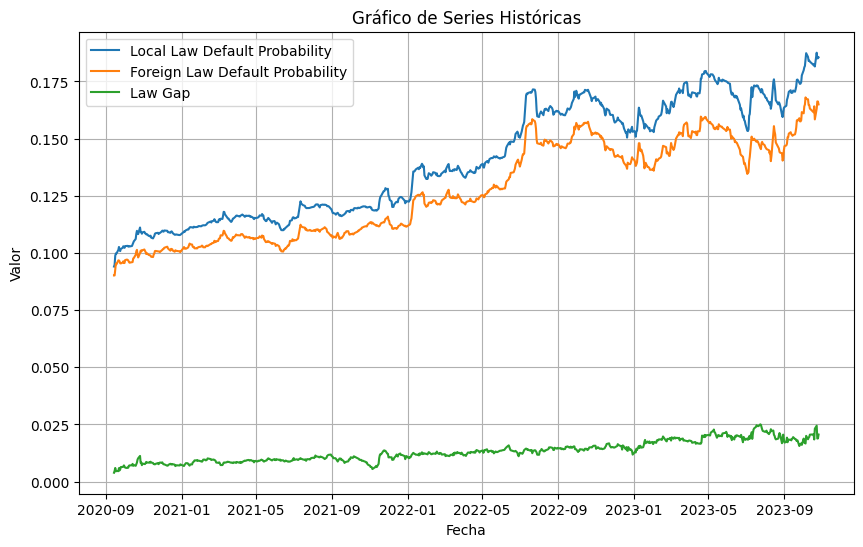

In [41]:
#Graficar La prob promedio de lo que es Ley Local y Ley Extranjera y también el GAP entre ambas

LL = PDs_LocalLaw
LL['Local Law Default Probability'] = LL.mean(axis=1)
LL = LL['Local Law Default Probability']

FL = PDs_ForeignLaw
FL['Foreign Law Default Probability'] = FL.mean(axis=1)
FL = FL['Foreign Law Default Probability']

Law_Gap = LL - FL

# Crear un gráfico de líneas para cada serie con leyenda
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

# Graficar cada serie y agregar una leyenda

plt.plot(LL.index, LL, label='Local Law Default Probability')
plt.plot(FL.index, FL, label='Foreign Law Default Probability')
plt.plot(Law_Gap.index, Law_Gap, label='Law Gap')


# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Gráfico de Series Históricas')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)

# Mostrar el gráfico
plt.show()


In [56]:
#Graficar la prob promedio según fecha de Vto

for i in range(len(Bonds_LocalLaw)):

    Bonds_LocalLaw[i][-2] = pd.DataFrame()
    #Bonds_LocalLaw[i][-2] = PDs_LocalLaw[i]
    #Bonds_LocalLaw[i][-2] = PDs_ForeignLaw[i]




TypeError: 'str' object does not support item assignment

In [50]:
Bonds_LocalLaw[1][-2:]

'30'